In [5]:
import torch
import torch.nn as nn
from model import UNET
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from dataset import DataPairsDataset
import constants
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import webdataset as wds
import pickle

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

all_targets = []
all_data = []
all_preds = []

def train_fn(loader, model, optimizer, loss_fn, scaler):
  loop = tqdm(loader)
  for batch_idx, (data, targets) in enumerate(loop):
    data = data.to(device = DEVICE)
    targets = targets.float().unsqueeze(1).to(device = DEVICE)
    all_targets.append(targets)
    all_data.append(data)
    # calculate the loss
    with torch.autocast(device_type=DEVICE):
      predictions = model(data)
      all_preds.append(predictions)
      loss = loss_fn(predictions, targets)

    # backwards step
    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()


    loop.set_postfix(loss = loss.item())

def main():
  train_transform = A.Compose(
    [
        A.RandomCrop(height = constants.IMAGE_HEIGHT, width = constants.IMAGE_WIDTH, p = 1.0),
        A.Rotate(limit = 35, p = 1.0),
        A.HorizontalFlip(p = 0.5),
        A.VerticalFlip(p = 0.1),
        A.Normalize(mean = 0, std = 1, max_pixel_value = constants.MAX_PIXEL_VALUE),
        ToTensorV2()
    ]
  )
  train_dataset = DataPairsDataset("train", transform=train_transform)
  train_loader = DataLoader(
    train_dataset,
    batch_size = constants.BATCH_SIZE,
    num_workers = constants.NUM_WORKERS,
    pin_memory = True,
    shuffle = True
    )


  model = UNET(in_channels = 1, out_channels = 1, features=constants.FEATURES).to(DEVICE)
  loss_fn = nn.BCEWithLogitsLoss()
  optimizer = optim.Adam(model.parameters(), lr = constants.LEARNING_RATE)
  scaler = torch.cuda.amp.GradScaler()

  for epoch in range(constants.NUM_EPOCHS):
    train_fn(train_loader, model, optimizer, loss_fn, scaler)

In [22]:
main()

/opt/miniconda3/envs/f_mlbase/lib/python3.10/site-packages/torch/cuda/amp/grad_scaler.py:126: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
100%|██████████| 28/28 [07:25<00:00, 15.90s/it, loss=-295]    


In [16]:
import torchvision.transforms as T
import matplotlib.pyplot as plt

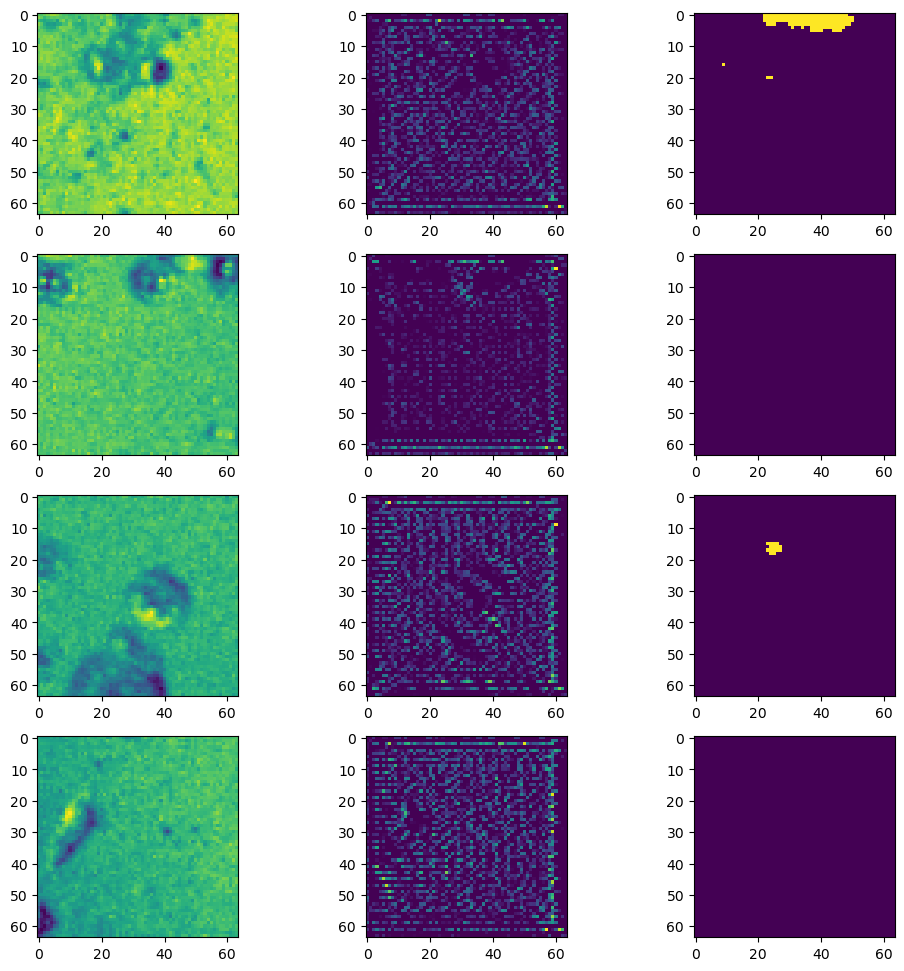

In [30]:
batch_idx = len(all_data) - 1
data_b1 = all_data[batch_idx]
target_b1 = all_targets[batch_idx]
pred_b1 = all_preds[batch_idx]

fig, ax = plt.subplots(nrows = data_b1.shape[0], ncols=3, figsize = (12, 12))
for i in range(data_b1.shape[0]):
    data = data_b1[i].squeeze()
    pred = pred_b1[i].squeeze().detach().to(torch.float32).numpy()
    target = target_b1[i].squeeze()
    ax[i][0].imshow(data)
    ax[i][1].imshow(pred)
    ax[i][2].imshow(target)
plt.show()

In [46]:
import boto3
import datetime
import io
import pickle

In [43]:
time = datetime.datetime.now().strftime("%m-%d_%H:%M:%S")

In [84]:
s3 = boto3.client("s3")
buffer = io.BytesIO()
tensor = [torch.randn(5, 3), torch.randn(5, 3), torch.randn(5, 3), torch.randn(5, 3)]
pickle.dump(tensor, buffer)
s3.put_object(Bucket = constants.BUCKET_NAME, Key = f"runs/{time}/deep_test.pickle", Body = buffer.getvalue())

{'ResponseMetadata': {'RequestId': 'ZY1636PV33GE3FS3',
  'HostId': 'g9fuyxy5buLGMwwRWH2E1JlKTDGWoBipFwasT3KpqRjGrWVfKV570TPQKypnjO+VnljH+VjaLCU=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'g9fuyxy5buLGMwwRWH2E1JlKTDGWoBipFwasT3KpqRjGrWVfKV570TPQKypnjO+VnljH+VjaLCU=',
   'x-amz-request-id': 'ZY1636PV33GE3FS3',
   'date': 'Tue, 26 Mar 2024 03:38:05 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"b13cf8b5c01a92d1485c2e48505225c3"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"b13cf8b5c01a92d1485c2e48505225c3"',
 'ServerSideEncryption': 'AES256'}

In [85]:
response = s3.get_object(Bucket = constants.BUCKET_NAME, Key = f"runs/{time}/deep_test.pickle")

In [86]:
byte_stream = response["Body"].read()
data = pickle.load(io.BytesIO(byte_stream))

In [87]:
data

[tensor([[-1.3839e+00,  1.9987e+00,  8.8466e-01],
         [ 4.3439e-01, -4.0603e-01,  1.6743e-01],
         [-1.7249e+00, -7.8867e-01,  3.3992e-01],
         [ 7.2762e-01, -1.5509e-03, -2.0037e-01],
         [-3.7522e-01,  4.4766e-01,  2.9121e-01]]),
 tensor([[-0.9803, -0.2879,  2.1510],
         [ 0.3263,  1.4618, -2.3576],
         [ 0.1317, -0.5874,  1.2844],
         [-0.3979, -1.5151, -0.8656],
         [-0.5019,  0.6533,  0.0402]]),
 tensor([[-0.8638,  1.5685,  0.5553],
         [ 0.2530,  1.2238, -0.4523],
         [ 0.2950,  0.4116, -0.9807],
         [ 1.5391, -3.0255,  0.2811],
         [-0.8144,  0.8505,  0.5066]]),
 tensor([[ 0.0361,  0.0966,  1.3602],
         [ 0.4925, -0.2739, -1.1826],
         [-0.9912,  0.1898, -0.5110],
         [-0.0131,  0.1877,  0.0407],
         [ 1.4871,  0.6567,  0.6206]])]

In [49]:
tensors = [torch.randn(10, 10), torch.randn(5, 5)]
buffer = io.BytesIO()

In [54]:
pickle.dump(tensors, buffer)

In [10]:
trainset = wds.WebDataset("./_cache/train.tar")

In [11]:
data = None
for item in trainset:
    data = pickle.loads(item["pkl"])
    break

In [12]:
data

['localhost231204150002_C02f04d2.TIFF',
 'localhost231204150002_C02f04d3.TIFF',
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])]